In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn
seaborn.set()

from current_model import DiscreteDipole
from bead_locating import calc_distances_1D, calc_distances_2D, mds

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

use_gpu = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_gpu \
        else torch.FloatTensor

## Creating Training Data

In [22]:
def forward_pass_np(T1,T2, input_field):
    
    field1 = T1@input_field
    intensity1 = abs(field1)**2
    return T2@intensity1, intensity1

In [23]:
#Initialise configuration
L = 500       #Medium height
beta = 15./L  #Medium height to width ratio
N_in = 100    #nb input points
N_out = 100   #nb output points
scat_density = 0.05   #Density of scattering particles 
N = round(scat_density*beta*L**2)    #nb scattering particles

#Initialising scattering system
system = DiscreteDipole(N,L,beta)

#Distance to medium from input and output planes
D_in = 0.5
D = 700  

#Producing forward propagation input and output coordinates
system.x_input = np.zeros(N_in) - D_in                              
system.y_input = np.linspace(0,L,N_in)                              
system.x_output = np.random.rand(N_out)*50 - 25 + D                 
system.y_output = np.linspace(0,L,N_out) 

In [24]:
#Bead configuration (manually initialised here)
config = np.zeros(system.N_in)
config[45] = 1
config[48] = 1
config[55] = 1
config[56] = 1
config[59] = 1


#Producing both TMs
system.bead_config = config
TM = system.TM_b
I_TM_back = system.I_TM_back_b
N_bead = system.N_bead

In [25]:
N_pat = 80000 #Number of input patterns
E0_max = 1    #Field amplitude

#Producing the input and output patterns
input_phi = np.random.rand(N_in,N_pat)*2*np.pi
input_field = E0_max*np.exp(input_phi*1j) #Consider changing E0_max for these input fields
output_intensity, I1 = forward_pass_np(TM,I_TM_back, input_field)

#Choose whether or not to add noise
noise = 0
beta_noise = .5

if noise == 1:
    I_mean = np.mean(output_intensity)
    output_intensity += beta_noise * np.random.randn(*output_intensity.shape)*I_mean

In [26]:
#Converting TMs and training data to pytorch tensor
T1_t = torch.from_numpy(TM).type(torch.cfloat)
T2_t = torch.from_numpy(I_TM_back).type(torch.float32)
SLM_input_t = torch.from_numpy(input_field).type(torch.cfloat)
CAM_output_t = torch.from_numpy(output_intensity).type(torch.float32)

#Transform data to dataloader
batch_size = 250 
training_data = TensorDataset(SLM_input_t.T,CAM_output_t.T)
training_dataloader = DataLoader(training_data, batch_size)

## Initialising Model

In [27]:
#Define a training process
def training_loop(dataloader, model, loss_fn, optimizer, T1, T2):
    size = len(dataloader.dataset)
    print(size)
    num_batches = int(size/dataloader.batch_size)
    
    #Initialising loss and correlation vectors over time
    loss_vec = torch.zeros(num_batches)
    cc1_mean = torch.zeros(num_batches)
    cc2_mean = torch.zeros(num_batches)

    for batch, (SLM_input, CAM_output) in enumerate(dataloader):
        #Compute model prediction and loss
        pred = model(SLM_input)
        loss = loss_fn(pred, CAM_output)
        loss_vec[batch] = loss
        
        #Step of gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Every 50 batches, printing an update on the loss
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(SLM_input)
            print(f"loss: {loss:>7e}  [{current:>5d}/{size:>5d}]", len(SLM_input))
        
        #Corelation matrix after particular step
        corel1 = torch.zeros((model.Nfluo , model.Nfluo))
        corel2 = torch.zeros((model.Nfluo , model.Nfluo))
        
        for tt in  torch.arange(0,model.Nfluo,1):
            for jj in  torch.arange(0,model.Nfluo,1):
                corel1[tt,jj] = torch.abs(torch.conj(T1[tt,:]).T @ model.T1.weight[jj,:]) / (torch.linalg.norm(T1[tt,:])*torch.linalg.norm(model.T1.weight[jj,:]))
                corel2[tt,jj] = torch.corrcoef(torch.stack(([T2[:,tt],model.T2.weight[:,jj]])))[1,0]
         
        #Reshaping these to produce corelation
        cc1 = torch.reshape(corel1 , (1, model.Nfluo*model.Nfluo))
        idex = (-cc1).argsort()[:model.Nfluo]
        cc1_mean[batch] = torch.mean(cc1[0,idex[0,:model.Nfluo]])
        cc2 = torch.reshape(corel2 , (1, model.Nfluo*model.Nfluo))
        idex = (-cc2).argsort()[:model.Nfluo]
        cc2_mean[batch] = torch.mean(cc2[0,idex[0,:model.Nfluo]])
    

    return loss_vec, cc1_mean, cc2_mean

In [28]:
#Defining a neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, Ncam, Nfluo, Nslm):
        super().__init__()
        #Determine structure of weights/TMs
        self.T1 = nn.Linear(Ncam, Nfluo, bias=False).to(torch.cfloat)
        self.T2 = nn.Linear(Nfluo, Nslm, bias=False)
        self.Nfluo = Nfluo

        #Manually initialise layers to ensure non-zero imaginary part of T1 
        #and prevent negative values in T2
        with torch.no_grad():
            self.T1.weight = torch.nn.Parameter(torch.randn(Nfluo,Nslm, dtype=torch.cfloat) * 1.8e-2)
            self.T2.weight = torch.nn.Parameter(abs(torch.randn(Ncam,Nfluo)) * 4e-4)
    
    #Forward pass using the model's weights
    def forward(self, SLM_input):
        int1 = torch.abs(self.T1(SLM_input))**2
        return self.T2(int1)

In [29]:
# Create network
model = NeuralNetwork(N_out, N_bead, N_in)

learning_rate = 1e-5 #Determinines SGD step size
epochs = 15  #Number of times dataset is analysed
momentum = 0.9  #Resistance of gradient to change

#Create loss function, optimiser and scheduler
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD([{'params': model.T1.parameters(), 'lr':3.5e5}, {'params': model.T2.parameters(), 'lr': 6.5e3}], momentum=momentum)
scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.4)

#Alternative scheduler
#scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

/Users/benmarrett/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:977: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


## Training Model

In [30]:
#Initialise overall loss and corelations vectors to track over time
loss_vec = torch.empty(0)
cc1_mean = torch.empty(0)
cc2_mean = torch.empty(0)


#Train network
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    
    #Each epoch produces correlation
    loss_vec_e, cc1_mean_e, cc2_mean_e= training_loop(training_dataloader, model, loss_fn, optimizer, T1_t, T2_t)
    
    #model.T2.weight.detach()[model.T2.weight.detach()<0] = 0   #trying to force T2 to be positive
    
    #Adding individual epoch loss vector to networks overall loss
    loss_vec = torch.cat((loss_vec,loss_vec_e),-1)
    cc1_mean = torch.cat((cc1_mean,cc1_mean_e),-1)
    cc2_mean = torch.cat((cc2_mean,cc2_mean_e),-1)
    
    #Scheduler adjusts learning rate
    scheduler1.step()
print("Done!")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1
-------------------------------
80000
loss: 8.591173e-09  [  250/80000] 250
loss: 9.565650e-10  [12750/80000] 250
loss: 2.625055e-10  [25250/80000] 250
loss: 1.935106e-10  [37750/80000] 250
loss: 1.532244e-10  [50250/80000] 250
loss: 1.062505e-10  [62750/80000] 250


  7%|▋         | 1/15 [00:01<00:16,  1.20s/it]

loss: 7.002917e-11  [75250/80000] 250
Epoch 2
-------------------------------
80000
loss: 5.456074e-11  [  250/80000] 250
loss: 4.164909e-11  [12750/80000] 250
loss: 3.658888e-11  [25250/80000] 250
loss: 3.402278e-11  [37750/80000] 250
loss: 2.692029e-11  [50250/80000] 250
loss: 2.812318e-11  [62750/80000] 250
loss: 2.767468e-11  [75250/80000] 250


 13%|█▎        | 2/15 [00:02<00:15,  1.17s/it]

Epoch 3
-------------------------------
80000
loss: 2.757967e-11  [  250/80000] 250
loss: 2.572483e-11  [12750/80000] 250
loss: 2.590849e-11  [25250/80000] 250
loss: 2.513565e-11  [37750/80000] 250
loss: 2.436008e-11  [50250/80000] 250
loss: 2.149817e-11  [62750/80000] 250
loss: 2.157210e-11  [75250/80000] 250


 20%|██        | 3/15 [00:03<00:13,  1.15s/it]

Epoch 4
-------------------------------
80000
loss: 2.223860e-11  [  250/80000] 250
loss: 1.858686e-11  [12750/80000] 250
loss: 1.648318e-11  [25250/80000] 250
loss: 1.611627e-11  [37750/80000] 250
loss: 1.398583e-11  [50250/80000] 250
loss: 1.147575e-11  [62750/80000] 250


 27%|██▋       | 4/15 [00:04<00:12,  1.18s/it]

loss: 1.091725e-11  [75250/80000] 250
Epoch 5
-------------------------------
80000
loss: 1.042034e-11  [  250/80000] 250
loss: 8.220064e-12  [12750/80000] 250
loss: 7.180163e-12  [25250/80000] 250
loss: 7.094686e-12  [37750/80000] 250
loss: 7.347953e-12  [50250/80000] 250
loss: 4.968730e-12  [62750/80000] 250
loss: 4.750601e-12  [75250/80000] 250


 33%|███▎      | 5/15 [00:06<00:12,  1.25s/it]

Epoch 6
-------------------------------
80000
loss: 3.797305e-12  [  250/80000] 250
loss: 3.759471e-12  [12750/80000] 250
loss: 3.508434e-12  [25250/80000] 250
loss: 3.269205e-12  [37750/80000] 250
loss: 3.242493e-12  [50250/80000] 250
loss: 2.618065e-12  [62750/80000] 250
loss: 2.095401e-12  [75250/80000] 250


 40%|████      | 6/15 [00:07<00:11,  1.25s/it]

Epoch 7
-------------------------------
80000
loss: 1.752820e-12  [  250/80000] 250
loss: 1.683918e-12  [12750/80000] 250
loss: 1.775083e-12  [25250/80000] 250
loss: 1.595292e-12  [37750/80000] 250
loss: 1.557057e-12  [50250/80000] 250
loss: 1.352466e-12  [62750/80000] 250


 47%|████▋     | 7/15 [00:08<00:09,  1.23s/it]

loss: 1.147796e-12  [75250/80000] 250
Epoch 8
-------------------------------
80000
loss: 1.046540e-12  [  250/80000] 250
loss: 9.643447e-13  [12750/80000] 250
loss: 1.063732e-12  [25250/80000] 250
loss: 9.858882e-13  [37750/80000] 250
loss: 9.125150e-13  [50250/80000] 250
loss: 8.683137e-13  [62750/80000] 250
loss: 7.556048e-13  [75250/80000] 250


 53%|█████▎    | 8/15 [00:09<00:08,  1.24s/it]

Epoch 9
-------------------------------
80000
loss: 7.104748e-13  [  250/80000] 250
loss: 6.343547e-13  [12750/80000] 250
loss: 7.051453e-13  [25250/80000] 250
loss: 6.668632e-13  [37750/80000] 250
loss: 6.070715e-13  [50250/80000] 250
loss: 5.990543e-13  [62750/80000] 250


 60%|██████    | 9/15 [00:10<00:07,  1.21s/it]

loss: 5.262414e-13  [75250/80000] 250
Epoch 10
-------------------------------
80000
loss: 4.987403e-13  [  250/80000] 250
loss: 4.341116e-13  [12750/80000] 250
loss: 4.827430e-13  [25250/80000] 250
loss: 4.581324e-13  [37750/80000] 250
loss: 4.182079e-13  [50250/80000] 250
loss: 4.143480e-13  [62750/80000] 250
loss: 3.668423e-13  [75250/80000] 250


 67%|██████▋   | 10/15 [00:12<00:06,  1.26s/it]

Epoch 11
-------------------------------
80000
loss: 3.475442e-13  [  250/80000] 250
loss: 2.972667e-13  [12750/80000] 250
loss: 3.316410e-13  [25250/80000] 250
loss: 3.132332e-13  [37750/80000] 250
loss: 2.878059e-13  [50250/80000] 250
loss: 2.835688e-13  [62750/80000] 250


 73%|███████▎  | 11/15 [00:13<00:05,  1.27s/it]

loss: 2.527873e-13  [75250/80000] 250
Epoch 12
-------------------------------
80000
loss: 2.387260e-13  [  250/80000] 250
loss: 2.019507e-13  [12750/80000] 250
loss: 2.268545e-13  [25250/80000] 250
loss: 2.126617e-13  [37750/80000] 250
loss: 1.963836e-13  [50250/80000] 250
loss: 1.923690e-13  [62750/80000] 250
loss: 1.723219e-13  [75250/80000] 250


 80%|████████  | 12/15 [00:14<00:03,  1.27s/it]

Epoch 13
-------------------------------
80000
loss: 1.621188e-13  [  250/80000] 250
loss: 1.362180e-13  [12750/80000] 250
loss: 1.543757e-13  [25250/80000] 250
loss: 1.436158e-13  [37750/80000] 250
loss: 1.329962e-13  [50250/80000] 250
loss: 1.298034e-13  [62750/80000] 250


 87%|████████▋ | 13/15 [00:16<00:02,  1.25s/it]

loss: 1.165840e-13  [75250/80000] 250
Epoch 14
-------------------------------
80000
loss: 1.093108e-13  [  250/80000] 250
loss: 9.146036e-14  [12750/80000] 250
loss: 1.046135e-13  [25250/80000] 250
loss: 9.667199e-14  [37750/80000] 250
loss: 8.962012e-14  [50250/80000] 250
loss: 8.733999e-14  [62750/80000] 250
loss: 7.851243e-14  [75250/80000] 250


 93%|█████████▎| 14/15 [00:17<00:01,  1.23s/it]

Epoch 15
-------------------------------
80000
loss: 7.343031e-14  [  250/80000] 250
loss: 6.126893e-14  [12750/80000] 250
loss: 7.068536e-14  [25250/80000] 250
loss: 6.496428e-14  [37750/80000] 250
loss: 6.022467e-14  [50250/80000] 250
loss: 5.869818e-14  [62750/80000] 250


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]

loss: 5.274085e-14  [75250/80000] 250
Done!


Loss minimization:   loss_final / loss_ init  =   tensor(5.6158e-06, grad_fn=<DivBackward0>)


<ipython-input-35-016cc9a2d20e>:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-np.max(loss_vec.detach().numpy()[:point]))


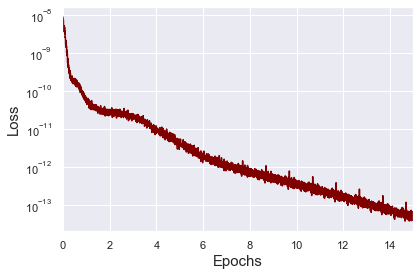

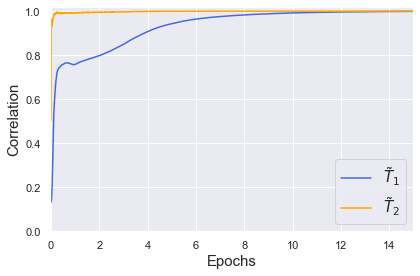

In [35]:
# How good is the reconstruction of the two TMs T1 (SLM <-> beads) and T2 (beads <-> CAM) ?
print('Loss minimization:   loss_final / loss_ init  =  ', loss_vec[-1] / loss_vec[0])

#Choose plotting range
point = len(loss_vec)
epoch_vals = np.linspace(0,point/len(loss_vec)*epochs,point) 

#Plot loss
fig, ax = plt.subplots() 
ax.plot(epoch_vals,loss_vec.detach().numpy()[:point], color='maroon')

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_yscale('log')
ax.set_xlim(-.05,np.max(epoch_vals))
ax.set_ylim(-np.max(loss_vec.detach().numpy()[:point]))

plt.tight_layout()
#plt.savefig('loss_graph_5beads.png', dpi=360)


#Plot TM correlations
fig, ax = plt.subplots() 
ax.plot(epoch_vals,cc1_mean.detach().numpy()[:point],'r', label=r'$\tilde{T}_1$', color='royalblue')
ax.plot(epoch_vals,cc2_mean.detach().numpy()[:point],'g', label = r'$\tilde{T}_2$', color='orange')

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)
ax.set_xlim(-.04,np.max(epoch_vals))
ax.set_ylim(0,1.02)
ax.legend(loc = 'lower right', fontsize=15)

plt.tight_layout()
#plt.savefig('correlation_graph_5beads.png', dpi=360)

## Target Reconstruction

### 1D

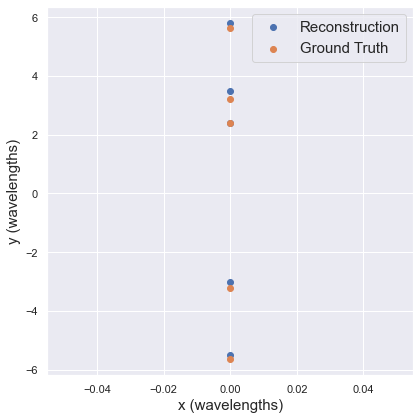

In [32]:
ds, correls = calc_distances_1D(model.T1.weight.detach().numpy(), system)

#Obtain coords
mds_x = mds(ds, correls, system)
mds_x -= np.median(mds_x)   #mds coords
target_x = system.y_output[system.bead_config.astype(bool)] #Real coords to compare
target_x -= np.median(target_x)

#Shifting to centre image
shift_x = (np.max(target_x) - abs(np.min(target_x)))/2
mds_x -= shift_x
target_x -= shift_x

#Plot
plt.figure(figsize=(6,6))
plt.scatter(np.zeros_like(mds_x)/(2*np.pi), mds_x/(2*np.pi), label='Reconstruction')
plt.scatter(np.zeros_like(target_x)/(2*np.pi), target_x/(2*np.pi), label='Ground Truth')

#Label
plt.xlabel('x (wavelengths)', fontsize=15)
plt.ylabel('y (wavelengths)', fontsize=15)
plt.legend(fontsize=15)

#Save
plt.tight_layout()
#plt.savefig('MDS_bead_reconstruction.jpg', dpi=360)

## 2D

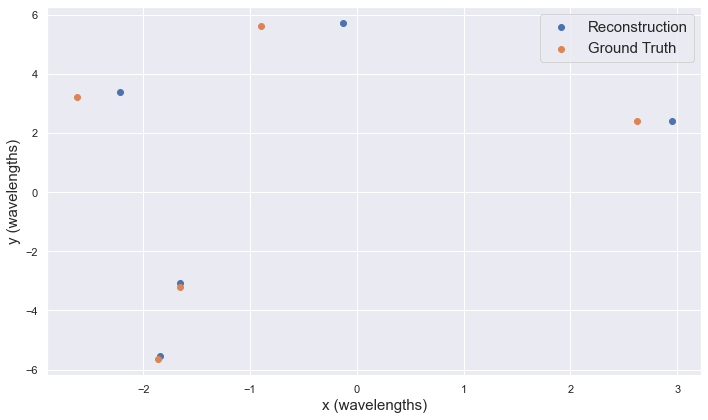

In [33]:
ds_x,ds_y, correls = calc_distances_2D(system.TM_b, system, num_correls_tilt=200, num_correls_shift=200)

#Obtain x coords
mds_x, inds_x = mds(ds_x, correls, system, return_inds=1)
mds_x -= np.median(mds_x)  #mds coords
target_x = system.y_output[system.bead_config.astype(bool)] #Real coords to compare
target_x -= np.median(target_x)

#Obtain y coords
mds_y, inds_yi = mds(ds_y, correls, system, return_inds=1)
inds_y = np.zeros(N_bead,dtype=int)
inds_y[inds_yi] = np.arange(0,system.N_bead,1)
mds_y = mds_y[inds_y][inds_x] #Resort to be the same order as x
mds_y -= np.median(mds_y)  #mds coords
target_y = system.x_output[system.bead_config.astype(bool)] #Real coords to compare
target_y -= np.median(target_y)

#Shifting to centre image
shift_x = (np.max(target_x) - abs(np.min(target_x)))/2
mds_x -= shift_x
target_x -= shift_x

shift_y = (np.max(target_y) - abs(np.min(target_y)))/2
mds_y -= shift_y
target_y -= shift_y

#Plot
plt.figure(figsize=(10,6))
plt.scatter(mds_y/(2*np.pi),mds_x/(2*np.pi), label='Reconstruction')
plt.scatter(target_y/(2*np.pi),target_x/(2*np.pi), label='Ground Truth')

#Label
plt.xlabel('x (wavelengths)', fontsize=15)
plt.ylabel('y (wavelengths)', fontsize=15)
plt.legend(fontsize=15)

#Save
plt.tight_layout()
#plt.savefig('MDS_bead_reconstruction.jpg', dpi=360)

In [34]:
def calc_err_position(pred_x, target_x, pred_y=[], target_y=[]):
    num = len(pred_x)
    
    xerrs = np.zeros(num)
    yerrs = np.zeros(num)
    
    for i, pred_x_i in enumerate(pred_x):
        xerrs[i] = np.min((target_x - pred_x_i)**2)
        
    if len(pred_y) != 0:
        for i, pred_y_i in enumerate(pred_y):
            yerrs[i] = np.min((target_y - pred_y_i)**2)
    
    err = ((xerrs)**2 + (yerrs)**2)**.5
    
    return np.mean(err)

print("Error in x = {:.3f}".format(calc_err_position(mds_x, target_x)/(2*np.pi)))
print("Error in y = {:.3f}".format(calc_err_position(mds_y, target_y)/(2*np.pi)))
print("Total error in position = {:.3f}".format(calc_err_position(mds_x, target_x, pred_y=mds_y, target_y=target_y)/(2*np.pi)))

Error in x = 0.080
Error in y = 1.040
Total error in position = 1.078
